# DQN Pro

## 一、简介
DQN 算法敲开了深度强化学习的大门，但是作为先驱性的工作，其本身存在着一些问题以
及一些可以改进的地方。于是，在 DQN 之后，学术界涌现出了非常多的改进算法。本章将介
绍其中两个非常著名的算法：Double DQN和 Dueling DQN，这两个算法的实现非常简单，只需
要在 DQN 的基础上稍加修改，它们能在一定程度上改善DQN的效果。

## 二、Double DQN
### 1.原因
普通的 DQN 算法通常会导致对Q 值的过高估计（overestimation）。

传统 DQN 优化的 TD误差目标为

$r+\gamma max_{a'}Q_{\omega^-}(s',a')$

其中，$max_{a'}Q_{\omega^-}(s',a')$
由目标网络（参数为$\omega^-$）计算得出，我们还可以将其写成如下形式：

$Q_{\omega^-}(s', arg  max_{a'}Q_{\omega^-}(s',a'))$

换句话说，max 操作实际上可以被拆解为两部分：首先选取状态 s′ 下的最优动作$a^*=argmax_{a'}Q_{\omega^-}(s',a')$,接着计算该动作对应的价值。

当这两部分采用同一套 Q 网络进行计算时，每次得到的都是神经网络当前估算的所有动作价值中的最大值。

考虑到通过神经网络估算的Q 值本身在某些时候会产生正向或负向的误差，
在 DQN 的更新方式下神经网络会将正向误差累积。

### 2.过高估计的示例
例如，我们考虑一个特殊情形：

在状态 s′ 下所有动作的Q 值均为 0，此时正确的更新目标应为r +0 = r 。


但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差的情况，
即存在某个动作a′ 有 Q(s′,a′)> 0，此时我们的更新目标出现
了过高估计：

$r+\gamma maxQ>r+0$

因此，当我们用 DQN 的更新公式进行更新时，Q(s, a) 也就会被过高估计了。

同理，我们拿这个Q(s, a)作为更新目标来更新上一步的 Q值时，同样会过高估计，这样的误差将会逐步累积。对于动作空间较大的任务，DQN 中的过高估计问题会非常严重，造成 DQN 无法有效工作的后果。

### 3.解决方案
为了解决这一问题，Double DQN 算法提出利用两套独立训练的神经网络来估算$max_{a'}Q_{\omega^-}(s',a')$。

具体做法：$max_{a'}Q_{\omega^-}(s',a')$替换为：$Q_{\omega^-}(s', arg  max_{a'}Q_{\omega^-}(s',a'))$

即利用一套神经网络 $Q_\omega$ 的输出来选取价值最大的动作，但在使用该动作的价值时，用另一套神经网
络 $Q_{\omega^-}$ 来计算该动作的价值。

这样，即使其中一套神经网络的某个动作存在比较严重的过高估计问题，
由于另一套神经网络的存在，
这个动作最终使用的 Q 值也不会存在很大的过高估计问题。

到此处为止，我们从最开始的：

Start       ------>    TD算法：Tabular (s,a)，离散的(s,a)的Q值

DQN         ------>    到DQN算法: DQN (s,a)，即用神经网络拟合的(s,a)函数

（注意，这里有q net也有target q net，且target q net的引入主要是为了便于梯度的计算）

Double DQN  ------>    再到Double DQN算法: Double DQN (s,a)，即防止神经网络中过高或过低的估计，
其中依然使用q net来选择Q值最大的动作，但是在计算上述中“Q值最大”的(s,a)时，使用target q net来计算。

## 三、Double DQN code
### 1.区别
显然，DQN与 Double DQN 的差别只在于计算状态s′ 下的 Q 值时如何选取动作

DQN 的TD Target:

$r+\gamma Q_{\omega^-}(s',argmax_{a'}Q_{\omega^-}(s',a'))$

Double DQN 的TD Target:

$r+\gamma Q_{\omega^-}(s',argmax_{a'}Q_{\omega}(s',a'))$

实际上，这里使用的新网络架构为Target Network（目标网络）

### 2.实现
环境是倒立摆（Inverted Pendulum），
该环境下有一个处于随机位置的倒立摆。

<img src="./media/pendulum.gif" style="zoom:60%;">

环境的状态包括倒立摆角度的正弦值、余弦值 、角速度；
动作为对倒立摆施加的力矩。

每一步都会根据当前倒立摆的状态好坏给予智能体不同的奖励，
倒立摆向上保持直立不动时奖励为0，
倒立摆在其他位置时奖励为负数。

环境本身没有终止状态，运行200 步后游戏自动结束。

In [76]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Hands_on_RL_Note import rl_utils
from tqdm import tqdm
from Hands_on_RL_Note.chapter8_DQN_Pro.Qnet import Qnet

In [77]:
class DQN:
    """ DQN算法,包括Double DQN """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [78]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作



In [79]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [80]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, _ = env.reset()
                terminated, truncated = False, False
                while not (terminated or truncated):
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, episode=200, return=-214.696]


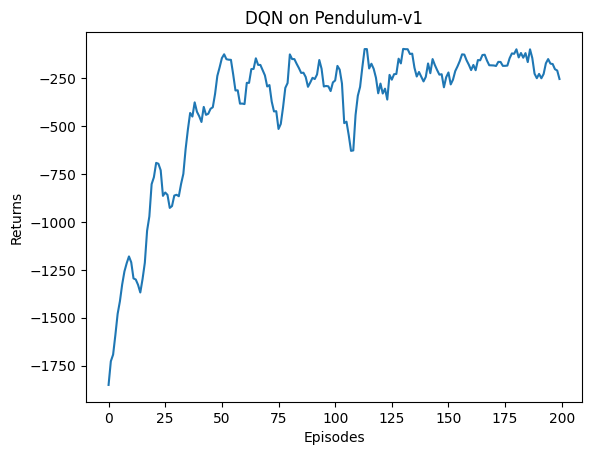

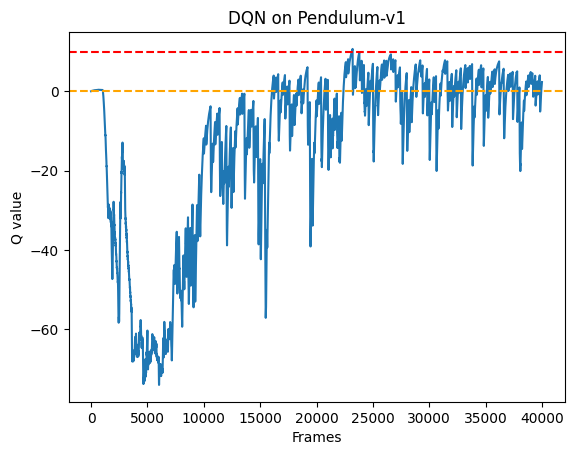

In [81]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s, episode=200, return=-198.204]


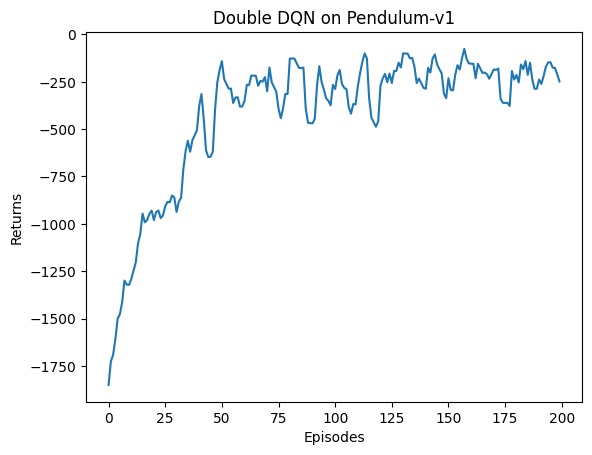

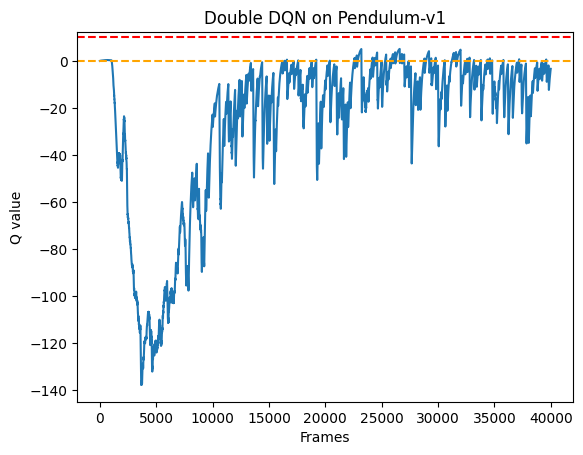

In [82]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()